The input data spreadsheets:

"training_data.csv":
There are 6950 training subjects. We are interested in predicting INBGR from the 62 IQMs. We are going to test random forest regression.

training_data.csv was generated from step1: Invicro_generate_training_dataset.ipynb

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline

In [2]:
csv_fn='./training_data.csv'
training_df = pd.read_csv(csv_fn)
training_df.shape

(6950, 76)

In [3]:
# check which columns contain NaN values
training_df.isnull().any()

Series               False
SeriesDescription    False
cjv                  False
cnr                  False
efc                  False
                     ...  
HEADCOVER            False
INHOMOGEN            False
IPMOTION             False
MARKER               False
PASS                 False
Length: 76, dtype: bool

In [4]:
# if any column shows True, you should remove columns with the nan value
# training_df = training_df.fillna(method='ffill')

In [5]:
training_df.describe()

,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,icvs_gm,...,INFLOW,OUTFLOW,INOTHER,OUTOTHER,WRAP,HEADCOVER,INHOMOGEN,IPMOTION,MARKER,PASS
count,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,...,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.0,6950.000000,6950.000000
mean,0.506589,2.653509,0.608864,1302.935511,3.216637,3.000013,3.492141,3.157757,0.232655,0.386209,...,0.383597,0.770072,0.029928,0.060000,0.305324,-0.002302,0.914964,-4.0,0.227626,0.975683
std,0.090549,0.459222,0.039450,5188.942354,0.448948,0.216474,0.622949,0.558836,0.019313,0.021665,...,0.598281,0.625244,0.209768,0.314649,0.531373,0.095941,0.298879,0.0,0.632944,0.155898
min,0.310715,0.702550,0.466283,1.408616,1.851547,1.275178,2.263096,1.534011,0.172994,0.050104,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-4.0,-1.000000,-1.000000
25%,0.442852,2.351951,0.581506,50.544709,2.789447,2.844753,2.860779,2.603452,0.220836,0.372907,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-4.0,0.000000,1.000000
50%,0.490205,2.660660,0.608856,89.864006,3.302929,3.002792,3.644010,3.265577,0.231513,0.386609,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-4.0,0.000000,1.000000
75%,0.549912,2.964434,0.635184,190.723816,3.589705,3.146459,4.014019,3.638243,0.243224,0.399810,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-4.0,0.000000,1.000000
max,1.056506,4.204148,0.845217,112390.585938,6.040375,4.048335,7.947968,6.124821,0.556633,0.487902,...,3.000000,3.000000,3.000000,3.000000,4.000000,2.000000,2.000000,-4.0,2.000000,1.000000


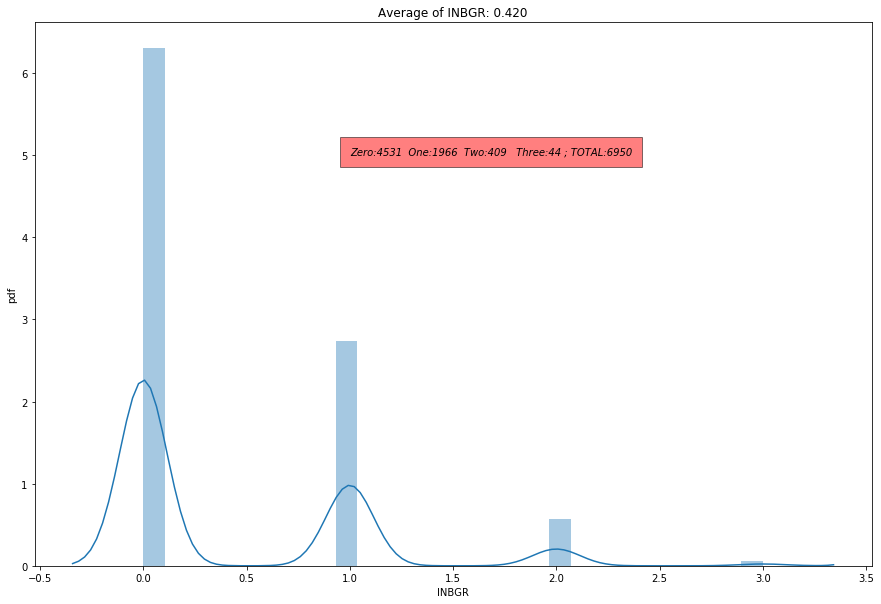

In [6]:
# check the disribution of INBGR
inbgr_mean = np.mean(training_df['INBGR'].values)
zeros = (training_df['INBGR'] == 0).astype(int).sum(axis=0)
ones = (training_df['INBGR'] == 1).astype(int).sum(axis=0)
twos = (training_df['INBGR'] == 2).astype(int).sum(axis=0)
threes = (training_df['INBGR'] == 3).astype(int).sum(axis=0)
total = zeros + ones + twos + threes

plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title('Average of INBGR: {:1.3f}'.format(inbgr_mean))
plt.text(1,5,"Zero:{}  One:{}  Two:{}   Three:{} ; TOTAL:{}".format(zeros,ones,twos,threes,total), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

## plot kde
plt.ylabel('pdf')
seabornInstance.distplot(training_df['INBGR'])

## plot histogram
#plt.ylabel('histogram')
#seabornInstance.distplot(training_df['INBGR'], hist=True, kde=False)

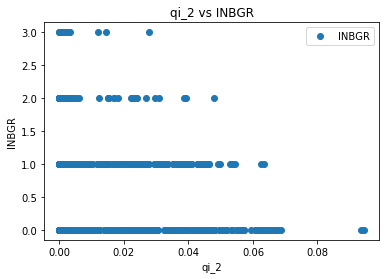

In [7]:
# Check how each mriqc measure is related to INBGR or eachother
xlabel = 'qi_2'
ylabel = 'INBGR'
title = xlabel + ' vs ' + ylabel
training_df.plot(x=xlabel, y=ylabel, style='o')  
plt.title(title)
plt.xlabel(xlabel)  
plt.ylabel(ylabel)  
plt.show()

# Set test/training data

In [8]:
headerlist = training_df.columns.values.tolist()
# print headers to find the index of the columns of interest
print ([list((i, headerlist[i])) for i in range(len(headerlist))])

[[0, 'Series'], [1, 'SeriesDescription'], [2, 'cjv'], [3, 'cnr'], [4, 'efc'], [5, 'fber'], [6, 'fwhm_avg'], [7, 'fwhm_x'], [8, 'fwhm_y'], [9, 'fwhm_z'], [10, 'icvs_csf'], [11, 'icvs_gm'], [12, 'icvs_wm'], [13, 'inu_med'], [14, 'inu_range'], [15, 'qi_1'], [16, 'qi_2'], [17, 'rpve_csf'], [18, 'rpve_gm'], [19, 'rpve_wm'], [20, 'snr_csf'], [21, 'snr_gm'], [22, 'snr_total'], [23, 'snr_wm'], [24, 'snrd_csf'], [25, 'snrd_gm'], [26, 'snrd_total'], [27, 'snrd_wm'], [28, 'summary_bg_k'], [29, 'summary_bg_mad'], [30, 'summary_bg_mean'], [31, 'summary_bg_median'], [32, 'summary_bg_n'], [33, 'summary_bg_p05'], [34, 'summary_bg_p95'], [35, 'summary_bg_stdv'], [36, 'summary_csf_k'], [37, 'summary_csf_mad'], [38, 'summary_csf_mean'], [39, 'summary_csf_median'], [40, 'summary_csf_n'], [41, 'summary_csf_p05'], [42, 'summary_csf_p95'], [43, 'summary_csf_stdv'], [44, 'summary_gm_k'], [45, 'summary_gm_mad'], [46, 'summary_gm_mean'], [47, 'summary_gm_median'], [48, 'summary_gm_n'], [49, 'summary_gm_p05'], [

In [9]:
predictors = headerlist[2:64]
X = training_df[predictors].values
y = training_df['INBGR'].values
# split 80% of the data to the training set while 20% of the data to test set
# Because data is imbalance use stratify in test_train_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 0)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
threes = (y_train == 3).astype(int).sum(axis=0)
print(threes)

(5560, 62)
(1390, 62)
(5560,)
(1390,)
35


# Multivariate Linear Regression

In [12]:
#training the algorithm
lm_model = LinearRegression()  
lm_model.fit(X_train, y_train)

y_pred_lm = lm_model.predict(X_test)
# Comparison between Actual and Predicted value
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lm})
df

,Actual,Predicted
0,0.0,0.514341
1,0.0,0.407907
2,0.0,0.321212
3,0.0,0.997424
4,0.0,0.113044
...,...,...
1385,2.0,0.738539
1386,1.0,0.206178
1387,1.0,0.353976
1388,1.0,1.112579


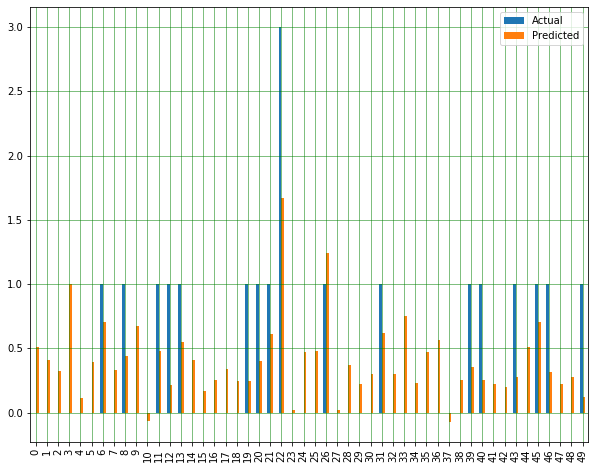

In [13]:
# plot some actual vs predicted samples
df1 = df.head(50)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [14]:
# Find linear regression coefficient for each predictor
coeff_df = pd.DataFrame(lm_model.coef_, training_df[predictors].columns, columns=['Coefficient'])

#pd.set_option('display.max_rows', None)
#display(coeff_df)

# sort values based on coef
#coeff_df.sort_values(by=['Coefficient'])

# sort values based on absolute value of coef
coeff_df_sorted = coeff_df.reindex(coeff_df.Coefficient.abs().sort_values(ascending=False).index)
coeff_df_sorted

,Coefficient
icvs_csf,7.203463e+00
qi_1,5.691316e+00
icvs_wm,-4.616723e+00
icvs_gm,-2.586739e+00
tpm_overlap_csf,2.395149e+00
...,...
summary_wm_n,-5.032199e-06
summary_bg_k,-1.748254e-06
summary_gm_n,7.729115e-07
fber,2.258298e-07


No handles with labels found to put in legend.


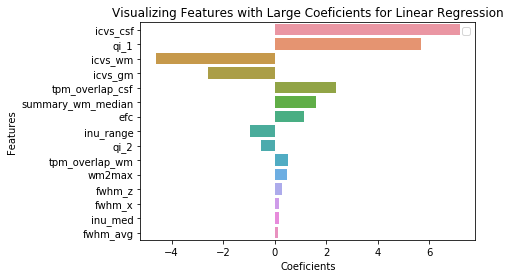

In [15]:
coeffs = pd.Series(coeff_df_sorted['Coefficient'],index=coeff_df_sorted.index)
coeffs1 = coeffs.head(15)
# Creating a bar plot
seabornInstance.barplot(x=coeffs1, y=coeffs1.index)
# Add labels to your graph
plt.xlabel('Coeficients')
plt.ylabel('Features')
plt.title("Visualizing Features with Large Coeficients for Linear Regression")
plt.legend()
plt.show()

In [16]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lm))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lm))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lm)))

Mean Absolute Error: 0.42331165619337974
Mean Squared Error: 0.3312467134487495
Root Mean Squared Error: 0.5755403664807096


In [18]:
r_squared_lm = metrics.r2_score(y_test, y_pred_lm)
print('R-squared:', r_squared_lm)  

R-squared: 0.17282936156261297


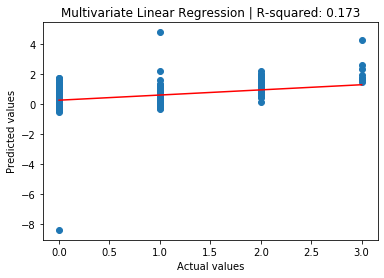

In [20]:
plt.scatter(y_test, y_pred_lm)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Multivariate Linear Regression | R-squared: {:1.3f}'.format(r_squared_lm))

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred_lm, 1))(np.unique(y_test)), color='red')

plt.show()

# GLM

# Modeled with poison regression

In [21]:
import statsmodels.api as sm
glm_model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
glm_results = glm_model.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5560
Model:                            GLM   Df Residuals:                     5501
Model Family:                 Poisson   Df Model:                           58
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3874.1
Date:                Fri, 17 Jul 2020   Deviance:                       3642.8
Time:                        17:34:48   Pearson chi2:                 3.89e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -3.5816      1.346     -2.662      0.0

In [22]:
y_pred_glm = glm_results.predict(X_test)
# Comparison between Actual and Predicted value
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_glm})
df

,Actual,Predicted
0,0.0,0.373294
1,0.0,0.304117
2,0.0,0.159757
3,0.0,0.559064
4,0.0,0.207675
...,...,...
1385,2.0,0.533766
1386,1.0,0.199771
1387,1.0,0.315041
1388,1.0,1.033427


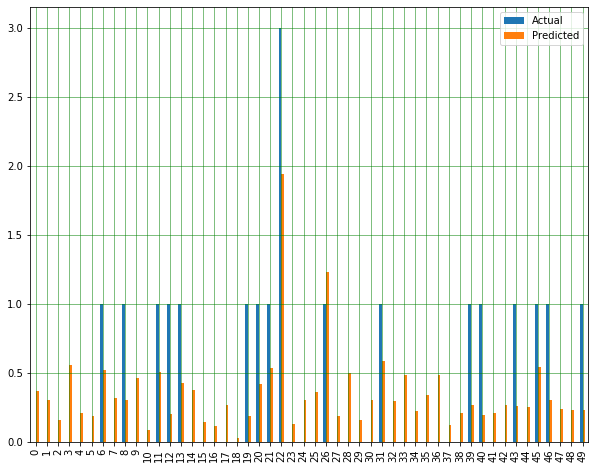

In [23]:
# plot some actual vs predicted samples
df1 = df.head(50)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [24]:
# Find linear regression coefficient for each predictor
coeff_df = pd.DataFrame(glm_results.params, training_df[predictors].columns, columns=['Coefficient'])

#pd.set_option('display.max_rows', None)
#display(coeff_df)

# sort values based on coef
#coeff_df.sort_values(by=['Coefficient'])

# sort values based on absolute value of coef
coeff_df_sorted = coeff_df.reindex(coeff_df.Coefficient.abs().sort_values(ascending=False).index)
coeff_df_sorted

,Coefficient
icvs_gm,-1.705236e+03
icvs_wm,-1.697430e+03
icvs_csf,-1.678435e+03
qi_1,1.969044e+01
qi_2,-1.185905e+01
...,...
summary_csf_n,-1.996804e-05
summary_bg_k,-1.306199e-05
summary_wm_n,-7.144646e-06
summary_gm_n,6.877725e-06


No handles with labels found to put in legend.


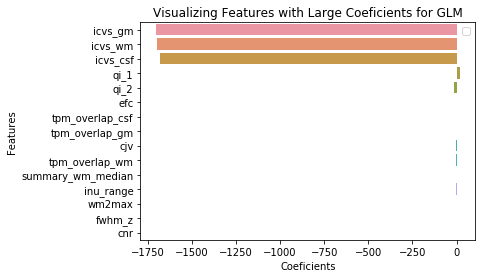

In [58]:
coeffs = pd.Series(coeff_df_sorted['Coefficient'],index=coeff_df_sorted.index)
coeffs1 = coeffs.head(15)
# Creating a bar plot
seabornInstance.barplot(x=coeffs1, y=coeffs1.index)
# Add labels to your graph
plt.xlabel('Coeficients')
plt.ylabel('Features')
plt.title("Visualizing Features with Large Coeficients for GLM")
plt.legend()
plt.show()

In [25]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_glm))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_glm))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_glm)))

Mean Absolute Error: 0.4322633154055444
Mean Squared Error: 0.4726314679145354
Root Mean Squared Error: 0.6874819764288628


In [26]:
r_squared_glm = metrics.r2_score(y_test, y_pred_glm)
print('R-squared:', r_squared_glm)

R-squared: -0.18022868510951406


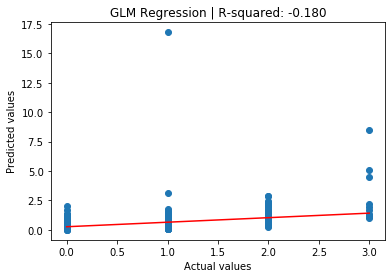

In [59]:
plt.scatter(y_test, y_pred_glm)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('GLM Regression | R-squared: {:1.3f}'.format(r_squared_glm))

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred_glm, 1))(np.unique(y_test)), color='red')

plt.show()

# Random Forest Regression With Default Parameters

In [49]:
# Set the regressor
# setting the random_state makes the results reproducible
rfr = RandomForestRegressor(n_estimators=100, random_state=0)

#Train the model using the training sets y_pred=clf.predict(X_test)
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [50]:
y_pred_rf = rfr.predict(X_test)
# Comparison between Actual and Predicted value
df = pd.DataFrame({'Actual': y_test, 'RF Predicted': y_pred_rf})
df

,Actual,Predicted
0,0.0,0.18
1,0.0,0.40
2,0.0,0.35
3,0.0,0.43
4,0.0,0.28
...,...,...
1385,2.0,1.38
1386,1.0,0.39
1387,1.0,0.16
1388,1.0,1.44


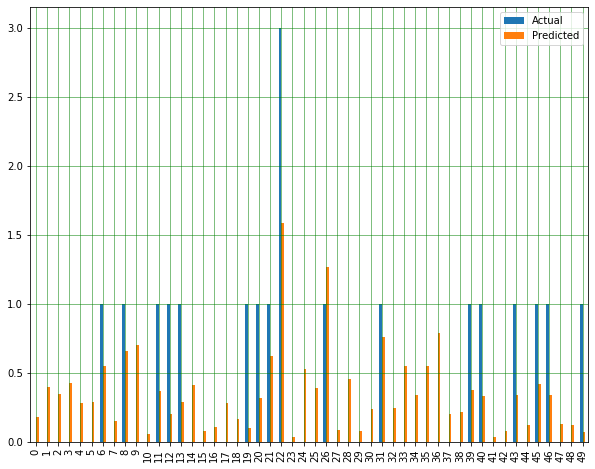

In [51]:
df1 = df.head(50)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [55]:
feature_imp = pd.Series(rfr.feature_importances_,index=training_df[predictors].columns).sort_values(ascending=False)
feature_imp

summary_wm_p95     0.153584
icvs_csf           0.102420
qi_2               0.034706
snrd_csf           0.027020
summary_wm_k       0.026055
                     ...   
snr_wm             0.005352
summary_bg_mean    0.004968
summary_wm_stdv    0.004896
snrd_wm            0.004835
summary_bg_mad     0.004490
Length: 62, dtype: float64

No handles with labels found to put in legend.


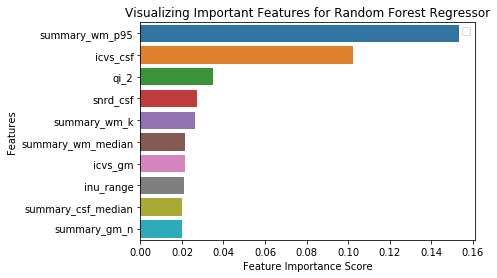

In [57]:
feature_imp1 = feature_imp.head(10)
# Creating a bar plot
seabornInstance.barplot(x=feature_imp1, y=feature_imp1.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features for Random Forest Regressor")
plt.legend()
plt.show()

In [52]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

Mean Absolute Error: 0.36543165467625893
Mean Squared Error: 0.22019345323741008
Root Mean Squared Error: 0.4692477525118368


In [53]:
# the score function returns r-squared
rfr.score(X_test,y_test)

0.4501453089215277

In [54]:
# r-squared could be calculated by metrics as well
r_squared_rf = metrics.r2_score(y_test, y_pred_rf)
print('R-squared:', r_squared_rf)  

R-squared: 0.4501453089215277


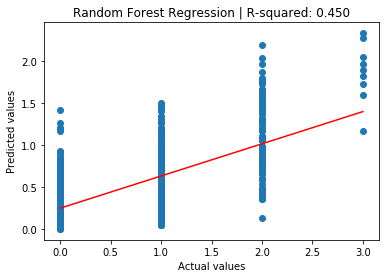

In [60]:
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Random Forest Regression | R-squared: {:1.3f}'.format(r_squared_rf))

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred_rf, 1))(np.unique(y_test)), color='red')

plt.show()

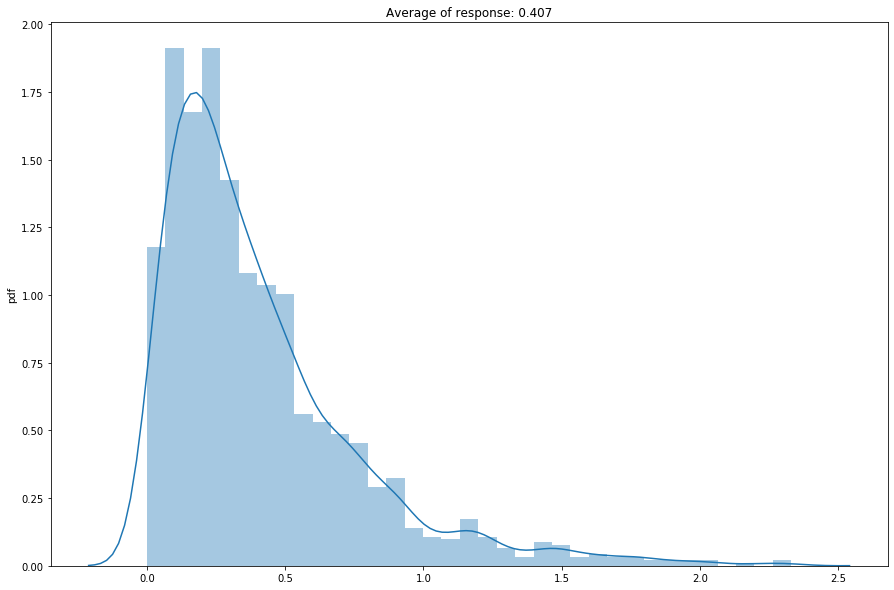

In [149]:
y_pred_mean = np.mean(y_pred_rf)
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title('Average of response: {:1.3f}'.format(y_pred_mean))

## plot kde
plt.ylabel('pdf')
seabornInstance.distplot(y_pred_rf)

## plot histogram
#plt.ylabel('histogram')
#seabornInstance.distplot(y_pred_rf, hist=True, kde=False)

# Find the optimized parameters set for the Random Forest Regressor using the Random Search

In [61]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'criterion': ['mse', 'mae'],
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', 'log2', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestRegressor(random_state = 0)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = None, cv = 5, 
                        n_iter = 20, verbose = 1, random_state=0)

# Fit 
rs.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 51.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 84.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [62]:
rs.best_params_

{'n_estimators': 41,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 42,
 'max_features': 0.7999999999999999,
 'max_depth': 8,
 'criterion': 'mse',
 'bootstrap': True}

In [63]:
rfr_opt = rs.best_estimator_

In [64]:
y_pred_rf_opt = rfr_opt.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'RF Predicted': y_pred_rf, 'Opt RF Predicted': y_pred_rf_opt})
df

,Actual,RF Predicted,Opt RF Predicted
0,0.0,0.18,0.427137
1,0.0,0.40,0.315693
2,0.0,0.35,0.230168
3,0.0,0.43,0.743517
4,0.0,0.28,0.227867
...,...,...,...
1385,2.0,1.38,1.323281
1386,1.0,0.39,0.216010
1387,1.0,0.16,0.188677
1388,1.0,1.44,1.106841


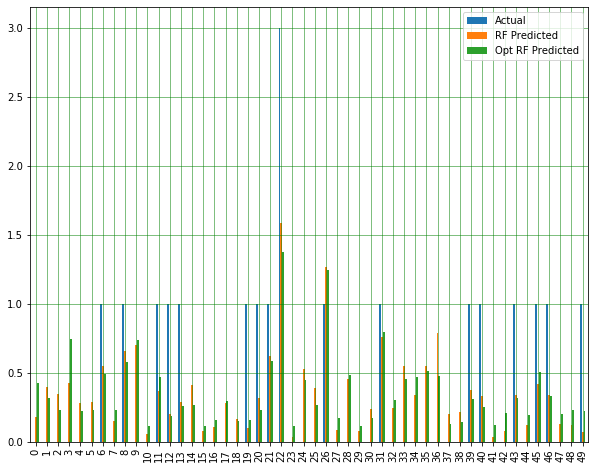

In [65]:
df1 = df.head(50)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [66]:
feature_imp = pd.Series(rfr_opt.feature_importances_,index=training_df[predictors].columns).sort_values(ascending=False)
feature_imp

summary_wm_p95    0.226502
icvs_csf          0.157546
qi_2              0.045222
summary_wm_k      0.044464
snrd_csf          0.037062
                    ...   
summary_gm_k      0.001903
inu_med           0.001796
snr_total         0.001772
summary_wm_p05    0.001759
cjv               0.001583
Length: 62, dtype: float64

No handles with labels found to put in legend.


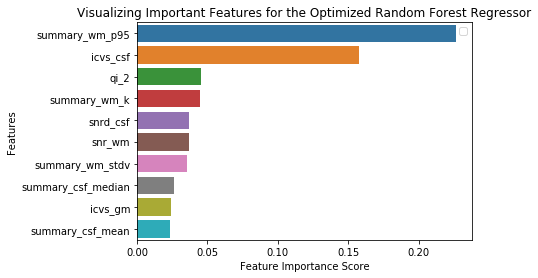

In [67]:
feature_imp1 = feature_imp.head(10)
# Creating a bar plot
seabornInstance.barplot(x=feature_imp1, y=feature_imp1.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features for the Optimized Random Forest Regressor")
plt.legend()
plt.show()

In [69]:
r_squared_rf_opt = rfr_opt.score(X_test,y_test)
r_squared_rf_opt

0.36701638696326133

In [70]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
print('R-squared:', metrics.r2_score(y_test, y_pred_rf))  
print('-------------------')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf_opt))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf_opt))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_opt)))
print('R-squared:', metrics.r2_score(y_test, y_pred_rf_opt))  

Mean Absolute Error: 0.36543165467625893
Mean Squared Error: 0.22019345323741008
Root Mean Squared Error: 0.4692477525118368
R-squared: 0.4501453089215277
-------------------
Mean Absolute Error: 0.4067745997729656
Mean Squared Error: 0.2534830562668794
Root Mean Squared Error: 0.5034710083677901
R-squared: 0.36701638696326133


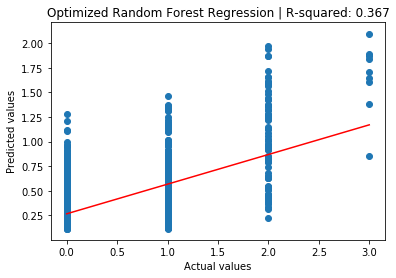

In [71]:
plt.scatter(y_test, y_pred_rf_opt)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Optimized Random Forest Regression | R-squared: {:1.3f}'.format(r_squared_rf_opt))

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred_rf_opt, 1))(np.unique(y_test)), color='red')

plt.show()

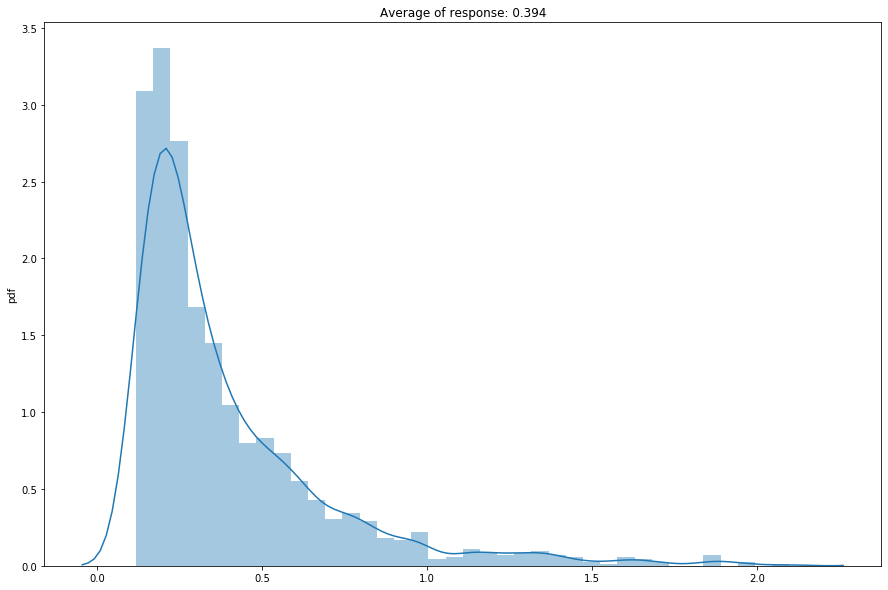

In [150]:
y_pred_opt_mean = np.mean(y_pred_rf_opt)
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title('Average of response: {:1.3f}'.format(y_pred_opt_mean))

## plot kde
plt.ylabel('pdf')
seabornInstance.distplot(y_pred_rf_opt)

## plot histogram
#plt.ylabel('histogram')
#seabornInstance.distplot(y_pred_rf_opt, hist=True, kde=False)

Check to see if results from default Random Forest and Original Random Forest are statistically different

In [151]:
from scipy import stats
stats.kruskal(y_pred_rf, y_pred_rf_opt)

KruskalResult(statistic=1.617904713136622, pvalue=0.20338419308677186)

In [152]:
from scipy.stats import f_oneway
f_oneway(y_pred_rf, y_pred_rf_opt)

F_onewayResult(statistic=1.1537190176472862, pvalue=0.28286526671130524)

# Conclusion:
The regressor with default parameters produced better results on test data. Perhaps because the model with optimal parameteres suffers from overfitting to the training data.

# Experiment: 
# Apply the Random Forest Regression (with default parameters) using only the first important feature

In [72]:
# print headers to find the index of the columns of interest
print ([list((i, headerlist[i])) for i in range(len(headerlist))])

[[0, 'Series'], [1, 'SeriesDescription'], [2, 'cjv'], [3, 'cnr'], [4, 'efc'], [5, 'fber'], [6, 'fwhm_avg'], [7, 'fwhm_x'], [8, 'fwhm_y'], [9, 'fwhm_z'], [10, 'icvs_csf'], [11, 'icvs_gm'], [12, 'icvs_wm'], [13, 'inu_med'], [14, 'inu_range'], [15, 'qi_1'], [16, 'qi_2'], [17, 'rpve_csf'], [18, 'rpve_gm'], [19, 'rpve_wm'], [20, 'snr_csf'], [21, 'snr_gm'], [22, 'snr_total'], [23, 'snr_wm'], [24, 'snrd_csf'], [25, 'snrd_gm'], [26, 'snrd_total'], [27, 'snrd_wm'], [28, 'summary_bg_k'], [29, 'summary_bg_mad'], [30, 'summary_bg_mean'], [31, 'summary_bg_median'], [32, 'summary_bg_n'], [33, 'summary_bg_p05'], [34, 'summary_bg_p95'], [35, 'summary_bg_stdv'], [36, 'summary_csf_k'], [37, 'summary_csf_mad'], [38, 'summary_csf_mean'], [39, 'summary_csf_median'], [40, 'summary_csf_n'], [41, 'summary_csf_p05'], [42, 'summary_csf_p95'], [43, 'summary_csf_stdv'], [44, 'summary_gm_k'], [45, 'summary_gm_mad'], [46, 'summary_gm_mean'], [47, 'summary_gm_median'], [48, 'summary_gm_n'], [49, 'summary_gm_p05'], [

In [73]:
predictors = headerlist[58]
X = training_df[predictors].values.reshape(-1,1)
y = training_df['INBGR']
# split 80% of the data to the training set while 20% of the data to test set
# Because data is imbalance use stratify in test_train_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 0)

In [74]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
threes = (y_train == 3).astype(int).sum(axis=0)
print(threes)

(5560, 1)
(1390, 1)
(5560,)
(1390,)
35


In [75]:
#Create a Gaussian Classifier
rfr1p = RandomForestRegressor(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rfr1p.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [76]:
y_pred_rf1p = rfr1p.predict(X_test)
# Comparison between Actual and Predicted value
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf1p})
df

,Actual,Predicted
2890,0.0,0.00
5988,0.0,0.39
6070,0.0,0.48
4116,0.0,0.16
4794,0.0,0.17
...,...,...
4229,2.0,0.93
3673,1.0,0.01
2642,1.0,0.05
5504,1.0,1.51


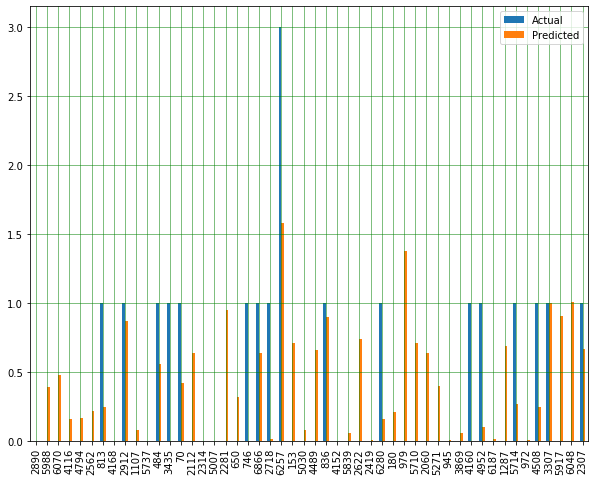

In [77]:
df1 = df.head(50)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [78]:
rfr1p.score(X_test,y_test)

-0.2919043494909166

In [79]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf1p))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf1p))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf1p)))

Mean Absolute Error: 0.513878417266187
Mean Squared Error: 0.5173528289972104
Root Mean Squared Error: 0.7192724303052428


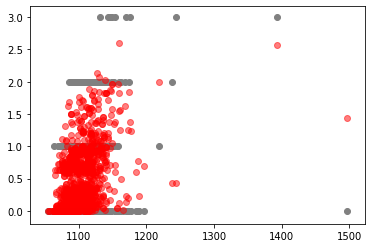

In [81]:
# plot linear regression line
plt.scatter(X_test, y_test,  color='gray')
plt.scatter(X_test, y_pred_rf1p, color='red', alpha=0.5)
plt.show()

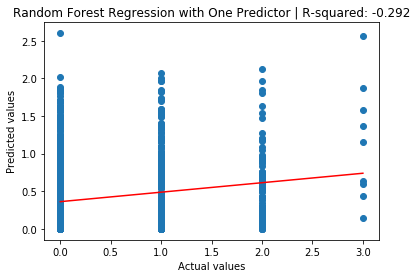

In [83]:
r_squared_rf1p = metrics.r2_score(y_test, y_pred_rf1p)
plt.scatter(y_test, y_pred_rf1p)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Random Forest Regression with One Predictor | R-squared: {:1.3f}'.format(r_squared_rf1p))

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred_rf1p, 1))(np.unique(y_test)), color='red')

plt.show()

# Experiment: 
# Apply the Random Forest Regression (with default parameters) using the first TWO important features

In [ ]:
# print headers to find the index of the columns of interest
#print ([list((i, headerlist[i])) for i in range(len(headerlist))])

In [84]:
predictors = [headerlist[10]] + [headerlist[58]]
X = training_df[predictors].values

y = training_df['INBGR']
# split 80% of the data to the training set while 20% of the data to test set
# Because data is imbalance use stratify in test_train_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 0)

In [85]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
threes = (y_train == 3).astype(int).sum(axis=0)
print(threes)

(5560, 2)
(1390, 2)
(5560,)
(1390,)
35


In [86]:
#Create a Gaussian Classifier
rfr2p = RandomForestRegressor(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rfr2p.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [89]:
y_pred_rf2p = rfr2p.predict(X_test)
# Comparison between Actual and Predicted value
df = pd.DataFrame({'Actual': y_test, 'RF Predicted with 1P': y_pred_rf1p, 'RF Predicted with 2P': y_pred_rf2p})
df

,Actual,RF Predicted with 1P,RF Predicted with 2P
2890,0.0,0.00,0.34
5988,0.0,0.39,0.46
6070,0.0,0.48,0.13
4116,0.0,0.16,1.05
4794,0.0,0.17,0.05
...,...,...,...
4229,2.0,0.93,1.06
3673,1.0,0.01,0.10
2642,1.0,0.05,0.39
5504,1.0,1.51,0.38


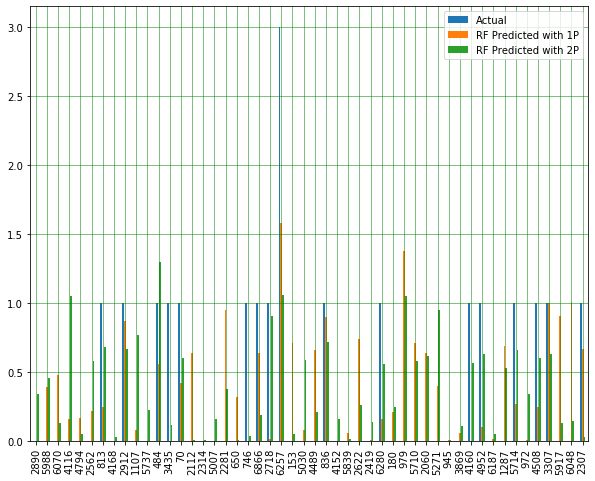

In [90]:
df1 = df.head(50)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [91]:
rfr2p.score(X_test,y_test)

0.12524050695079914

In [92]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf1p))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf1p))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf1p)))
print('------------')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf2p))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf2p))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf2p)))

Mean Absolute Error: 0.513878417266187
Mean Squared Error: 0.5173528289972104
Root Mean Squared Error: 0.7192724303052428
------------
Mean Absolute Error: 0.44997122302158277
Mean Squared Error: 0.3503040287769784
Root Mean Squared Error: 0.5918648737482048


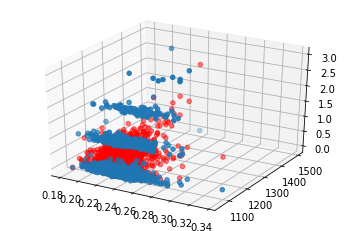

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:,0], X_test[:,1], y_test, zdir='z')
ax.scatter(X_test[:,0], X_test[:,1], y_pred_rf2p, zdir='z', c='red', alpha=0.5)

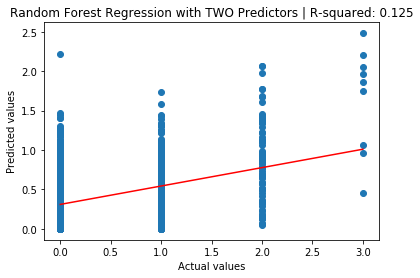

In [94]:
r_squared_rf2p = metrics.r2_score(y_test, y_pred_rf2p)
plt.scatter(y_test, y_pred_rf2p)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Random Forest Regression with TWO Predictors | R-squared: {:1.3f}'.format(r_squared_rf2p))

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred_rf2p, 1))(np.unique(y_test)), color='red')

plt.show()

# SVM Regression

Regression problems involve the task of approximating a mapping function from input variables to a continuous output variable. The approach of using SVMs to solve regression problems is called Support Vector Regression (SVR).

In [121]:
import math
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.svm import SVR

In [122]:
headerlist = training_df.columns.values.tolist()
# print headers to find the index of the columns of interest
#print ([list((i, headerlist[i])) for i in range(len(headerlist))])

In [123]:
predictors = headerlist[2:64]
X = training_df[predictors].values
y = training_df['INBGR'].values
# shuffle the data
X, y = shuffle(X, y, random_state=42)
# split 80% of the data to the training set while 20% of the data to test set
# Because data is imbalance use stratify in test_train_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 0)

In [124]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
threes = (y_train == 3).astype(int).sum(axis=0)
print(threes)

(5560, 62)
(1390, 62)
(5560,)
(1390,)
35


In [125]:
# normalize the data set
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [126]:
#Create a Gaussian Classifier
svr = SVR(kernel='rbf')

#Train the model using the training sets y_pred=clf.predict(X_test)
svr.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [127]:
y_pred_svr = svr.predict(X_test)
# Comparison between Actual and Predicted value
df = pd.DataFrame({'Actual': y_test, 'SVR Predicted': y_pred_svr})
df

,Actual,SVR Predicted
0,0.0,0.733039
1,0.0,0.477288
2,0.0,0.657728
3,0.0,0.831832
4,0.0,0.341145
...,...,...
1385,2.0,1.083579
1386,1.0,1.149728
1387,1.0,0.716338
1388,1.0,1.128393


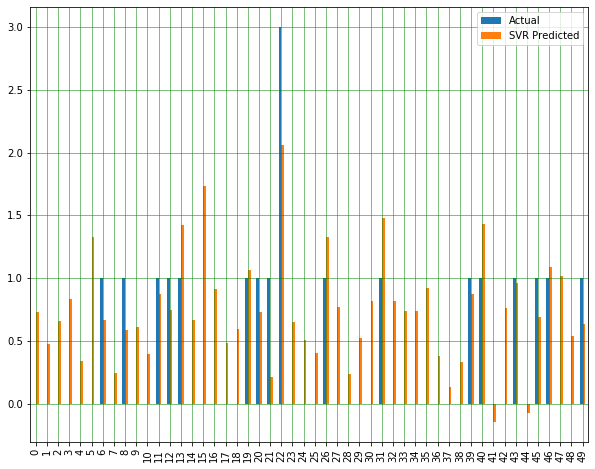

In [128]:
df1 = df.head(50)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [129]:
svr.score(X_test,y_test)

0.04937212990450679

In [130]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_svr))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_svr))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_svr)))

Mean Absolute Error: 0.5084389288064193
Mean Squared Error: 0.38068609190091895
Root Mean Squared Error: 0.6169976433511873


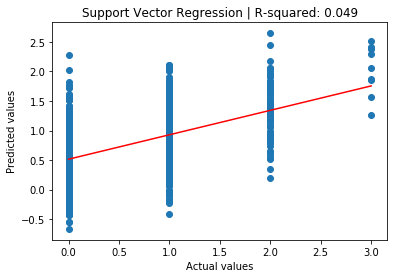

In [131]:
r_squared_svr = metrics.r2_score(y_test, y_pred_svr)
plt.scatter(y_test, y_pred_svr)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Support Vector Regression | R-squared: {:1.3f}'.format(r_squared_svr))

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred_svr, 1))(np.unique(y_test)), color='red')

plt.show()

# Find the optimized parameters set for SVR using a grid search

In [132]:
# def svr_model(X, y):
#     gsc = GridSearchCV(
#         estimator=SVR(kernel='rbf'),
#         param_grid={
#             'C': [0.1, 1, 100, 1000],
#             'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
#             'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
#         },
#         cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

#     grid_result = gsc.fit(X, y)
#     best_params = grid_result.best_params_
#     best_svr = SVR(kernel='rbf', C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"],
#                    coef0=0.1, shrinking=True,
#                    tol=0.001, cache_size=200, verbose=False, max_iter=-1)

#     scoring = {
#                'abs_error': 'neg_mean_absolute_error',
#                'squared_error': 'neg_mean_squared_error'}

#     scores = cross_validate(best_svr, X, y, cv=10, scoring=scoring, return_train_score=True)
#     return "MAE :", abs(scores['test_abs_error'].mean()), "| RMSE :", math.sqrt(abs(scores['test_squared_error'].mean()))

In [133]:
# # Run 
# print(svr_model(X,y))

# Random Forest Regression (using default parameters) and normalized data

In [134]:
# Set the regressor
# setting the random_state makes the results reproducible
rfr_nor = RandomForestRegressor(n_estimators=100, random_state=0)

#Train the model using the training sets y_pred=clf.predict(X_test)
rfr_nor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [135]:
y_pred_rf_nor = rfr_nor.predict(X_test)
# Comparison between Actual and Predicted value
df = pd.DataFrame({'Actual': y_test, 'RF Predicted': y_pred_rf, 'RF Predicted (normalized data)': y_pred_rf_nor})
df

,Actual,RF Predicted,RF Predicted (normalized data)
0,0.0,0.18,0.64
1,0.0,0.40,0.87
2,0.0,0.35,0.57
3,0.0,0.43,0.85
4,0.0,0.28,0.81
...,...,...,...
1385,2.0,1.38,1.04
1386,1.0,0.39,1.29
1387,1.0,0.16,0.87
1388,1.0,1.44,1.11


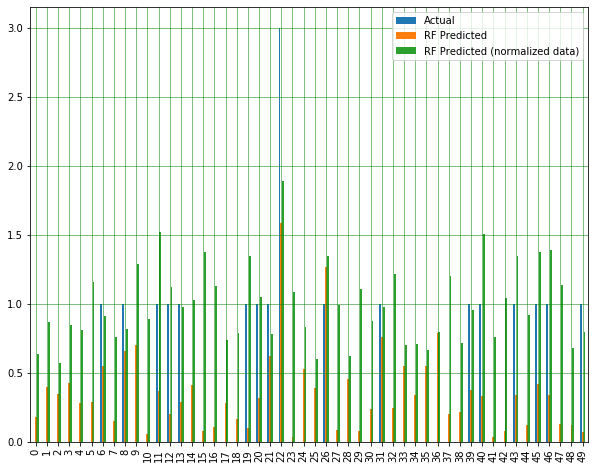

In [136]:
df1 = df.head(50)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [137]:
feature_imp = pd.Series(rfr_nor.feature_importances_,index=training_df[predictors].columns).sort_values(ascending=False)
feature_imp

summary_wm_p95     0.145889
icvs_csf           0.112046
qi_2               0.039161
snrd_csf           0.029968
icvs_gm            0.023393
                     ...   
summary_gm_mean    0.005962
snr_wm             0.005828
summary_bg_mad     0.005705
summary_bg_mean    0.005230
summary_wm_stdv    0.004950
Length: 62, dtype: float64

No handles with labels found to put in legend.


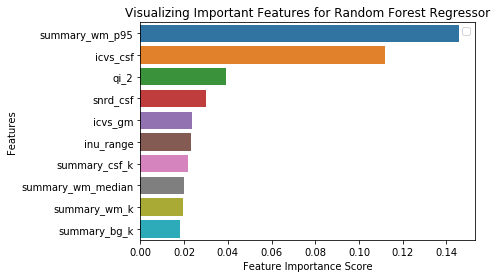

In [138]:
feature_imp1 = feature_imp.head(10)
# Creating a bar plot
seabornInstance.barplot(x=feature_imp1, y=feature_imp1.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features for Random Forest Regressor")
plt.legend()
plt.show()

In [139]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
print('-------')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf_nor))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf_nor))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_nor)))

Mean Absolute Error: 0.36543165467625893
Mean Squared Error: 0.22019345323741008
Root Mean Squared Error: 0.4692477525118368
-------
Mean Absolute Error: 0.7032230215827339
Mean Squared Error: 0.6377612949640288
Root Mean Squared Error: 0.7985995836237512


In [140]:
# the score function returns r-squared
rfr_nor.score(X_test,y_test)

-0.5925815898175575

In [142]:
# r-squared could be calculated by metrics as well
r_squared_rf_nor = metrics.r2_score(y_test, y_pred_rf_nor)
print('R-squared:', r_squared_rf_nor)  

R-squared: -0.5925815898175575


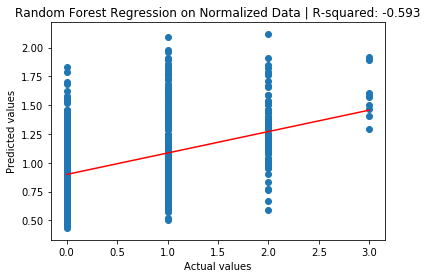

In [143]:
plt.scatter(y_test, y_pred_rf_nor)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Random Forest Regression on Normalized Data | R-squared: {:1.3f}'.format(r_squared_rf_nor))

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred_rf_nor, 1))(np.unique(y_test)), color='red')

plt.show()